<a href="https://colab.research.google.com/github/FHnt97/TOM_Thesis/blob/main/WLK_MMH_Debiasing_Classification_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fairness in Occupational Fatigue Detection
    

# Content

---


- **Dataset**
    - MMH & WLK datasets (merged)
    - **Sensitive attribute**: age (in buckets of 10 years) & task
    - The dataset has an unqeual sample size for both age and task groups. 

- **Domain**
    - Operations management - fatigue detection 

- **ML task**
    - SVM (rbf)
    - RFC 
    - LinearClassifier

- **Fairness tasks**
    - Assessment of unfairness 
    - Mitigation of unfairness with a focus on equal **FALSE NEGATIVE RATE** and **SELECTION RATE**


- **Model performance metrics**:
    - Confusion matrix
    - Recall, accuracy & precision
    - ROC curve

- **Model fairness metrics**:
    - Equalized odds /  False negatives and False negative rate
    - Selection Rate

- **Mitigation algorithms**:

*the objective is to reduce false negatives / make them equal (avoid burn out of employees)*

    - Reweighting (aif360)
    - Exponential gradient (fairlearn - postprocessing)
    - ThresholdOptimizer (fairlearn - postprocessing)

> NOTE: all models are trained unawarene of the sensitive attribue -- sensitive attributes are not inlcuded in training data: 

```
    C=c(x, A) = c(X)
```



> HOWEVER: in Operations management, and especially in the measure of fatigue, physiological data is used for each participant, this can act as a proxy to the sensitive attribute. 



> NOTE: a FN means that someone who's stressed was not identifies and therefore recieved no support -- if stress/ fatigue is NOT detected when present, it can lead to dangerous situations for employees/ burnouts in the long term 





```
# Nomeclature: 

X ∈ Rᵈ: quantified features of the applicant

A ∈ {0, 1}: binary sensitive attribute gnder

C :=c(X,A) ∈ {0,1}: binary predictor (stressed vs. ok), which makes decision based on a score R:=r(x, a) ∈ [0,1]

Y ∈ {0, 1}: target variable

```

    



For ths final representation of the model a **MODEL CARD** will be presented. 


# Base code
------

Using the work by [Maman et al. (2020)](https://zahrame.github.io/FatigueManagement.github.io/) as a base, we apply a fairness unaware model, namely **SVM (circular kernel), RF and a a generic lgm model (logistic regression).** 


> Note - decision trees are non-parametric supervised learning models for classigfication 


Lasso/ best subset selection methods were applied for feature selection, following the combinations with the highest accuracy in the [report](https://www.sciencedirect.com/science/article/pii/S0957417420302293) by Maman et al. (2020).
Cross validation scores were taken to ensure the performance of the generic model for all participants.  

### Libraries

In [1]:
# importing general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from IPython import display
from datetime import date

In [ ]:
# !pip install model-card-toolkit
!pip install --upgrade fairlearn==0.7.0
!pip install fairml
!pip install aif360

### Data load and wrangling

In [3]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# open csv datasets
# if using collab use -->
pathMMH = '/content/drive/MyDrive/00 - thesis/Code/Datasets/Fatigue-modeling-master/MMH_15p.csv'
pathWLK = '/content/drive/MyDrive/00 - thesis/Code/Datasets/Fatigue-modeling-master/WLK_13p.csv'

# if using the GitHub repo use -->
# pathMMH = './Datasets/Fatigue-modeling-master/MMH_15p.csv'
# pathWLK = './Datasets/Fatigue-modeling-master/WLK_13p.csv'

df_MMH = pd.read_csv(pathMMH, sep=',')
df_WLK = pd.read_csv(pathWLK, sep=',')

In [5]:
# make column names the same for both dfs
df_MMH['fatiguestate'] = df_MMH['fatiguestate1']
df_WLK['fatiguestate'] = df_WLK['Fatigue state']
df_WLK['subject'] = df_WLK['subject'].apply(lambda x: x+'00')

df_MMH.rename(columns = {'age':'Age', 'HRR-Mean': 'HRR.Mean', 'HRR-CV':'HRR.CV'}, inplace = True)
df_MMH.columns = df_MMH.columns.str.replace('coefficient.of.variation', 'CV')

df_MMH = df_MMH.drop(['fatiguestate1'], 1)
df_WLK = df_WLK.drop(['Fatigue state'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.


In [6]:
# merge datasets
df = pd.concat([df_MMH, df_WLK])

In [7]:
df = df.dropna(axis='columns')

In [8]:
# delete:
## fatiguestate (already in fatiguestate1); Unnamed (no critical information); gender (only available in one dataset)
df = df.drop(['Unnamed: 0'],1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
df.task.unique()

array(['MMH', 'WLK'], dtype=object)

In [10]:
# convert subject & task to numerical values 
df['subject'] = df['subject'].str.replace('P','')
df['task'] = df['task'].str.replace('MMH', '1')
df['task'] = df['task'].str.replace('WLK', '2')

task
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Age, dtype: object

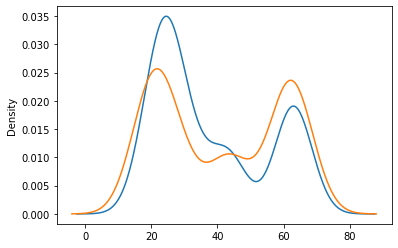

In [11]:
# check gender & age representation 
df.groupby('task').Age.plot(kind='kde')

In [12]:
# bin age into groups to noramlize
def custom_round(x, base):
    return base * round(float(x)/10)

df['Age'] = df.Age.apply(lambda x: custom_round(x, 10))

In [13]:
# for this dataset features are NOT normalised, as preprocessing of data has already peen carried out by the owners of the dataset. How this is done is described in detail in their code & paper cited above. 
# in case of wanting to normalise, I would suggest normalising only mean values - variation has already been pre-calculated, and so is the HHR values (% of total possible HR)
# you can use (pandas or sklearn library 'preprocessing.MinMaxScaler'): 
# normalized_df=(df-df.min())/(df.max()-df.min())
# normalized_df=(df-df.mean())/df.std()


'''https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame'''

'https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame'

### Exploratory analysis 

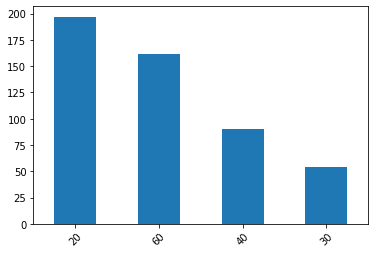

In [46]:
# there are 18 entries per subject
# get distributions 
df["Age"].value_counts().plot(kind='bar', rot=45)

In [47]:
# drop subject as it is not relevant for analysis
df_1 = df.drop(['subject'],1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


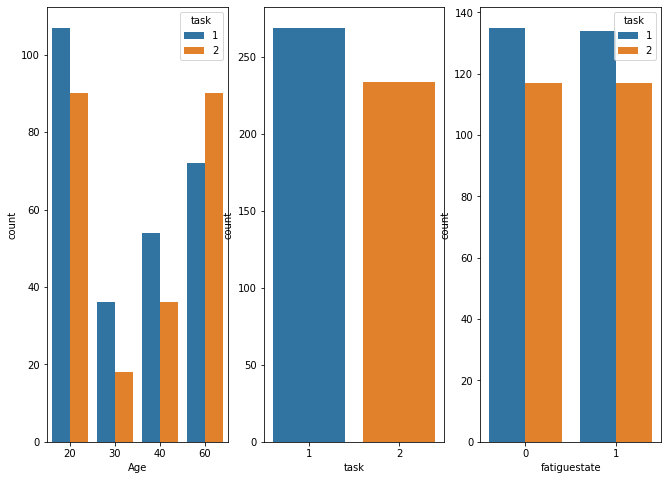

In [48]:
# check sample distributions
fig, ax = plt.subplots(1,3)
fig.set_size_inches(11, 8)
sns.countplot(df_1['Age'], ax=ax[0], hue=df_1.task)
sns.countplot(df_1['task'], ax=ax[1])
sns.countplot(df_1['fatiguestate'], ax=ax[2], hue=df_1.task)
fig.show()

Task and fatigue state is well distributes in sample; age is not (1 participant has about 18 entries, there are only 2 participants in their 30s)

Pairplots analysis not appropiate with the high number of attributes therefore deleted.


In [49]:
# define df with only attriutes that are needed & significant according to correlation analysis below
df.columns
cols = ['subject', 'task', 'Age', 'fatiguestate',  
        'HRR.Mean', 'HRR.CV',
        'Wrist.jerk.Mean', 
        'Ankle.jerk.Mean', 'Ankle.ACC.Mean', 'Ankle.xposture.Mean',
        'number of steps', 'average step time', 'average step distance',
        'time bent', 
        'mean hip osicllation', 'mean foot osicllation', 
        'leg rotational velocity sag plane', 'leg rotational position sag plane', 
        'Wrist.jerk.CV', 'Wrist.ACC.CV',
        'Hip.jerk.CV', 'Hip.ACC.CV', 'Hip.yposture.CV']

cols_rfc = ['subject', 'task', 'Age', 'fatiguestate', 
            'HRR.Mean', 'HRR.CV', 
            'Wrist.jerk.Mean', 'Ankle.xposture.Mean',
            'average step time', 
            'leg rotational velocity sag plane',
            'leg rotational position sag plane',
            'Wrist.jerk.CV', 'Wrist.ACC.CV', 
            'Hip.ACC.CV']

# for cross validation, we get better refults if we don't implement the rfc attributes only 

df = df[cols]

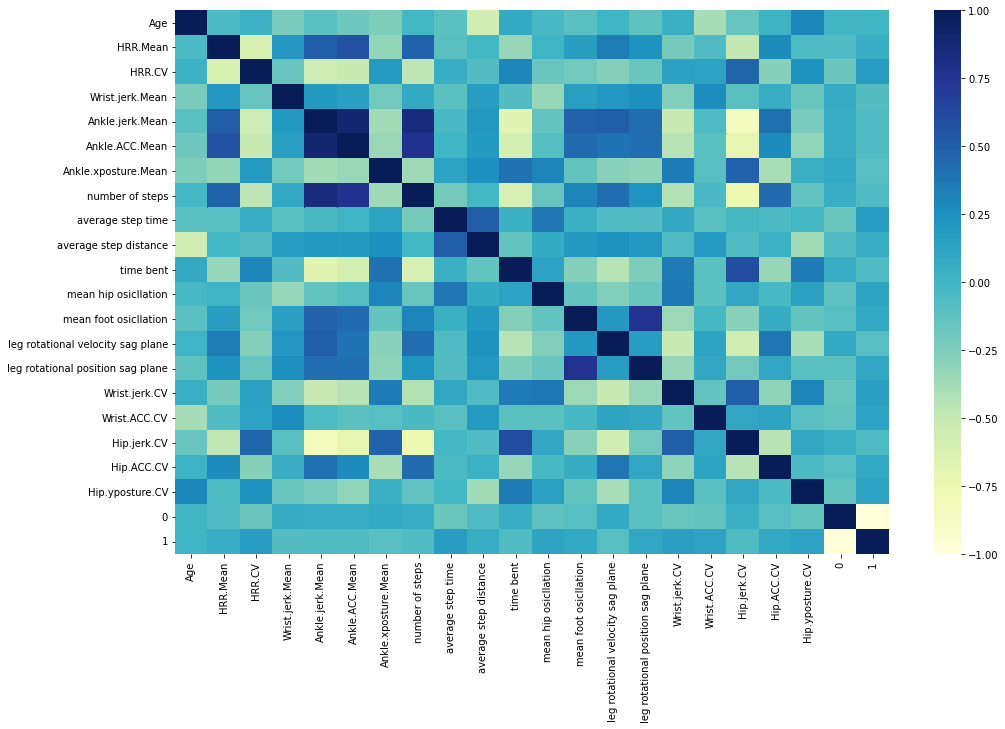

In [19]:
# correlation analysis 
df_corr = pd.concat([df.drop('fatiguestate', axis=1), pd.get_dummies(df['fatiguestate'])], axis=1)
corr = df_corr.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr,  cmap="YlGnBu")

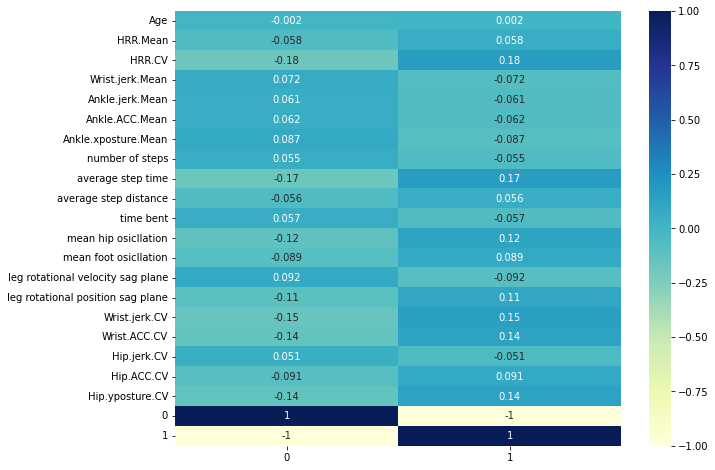

In [20]:
# all features with a corr. under |0.05| are removed
feats = df.columns[1:]

df_corr = pd.concat([df[feats].drop('fatiguestate', axis=1), pd.get_dummies(df[feats]['fatiguestate'])], axis=1)
corr = df_corr.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr[[0,1]], annot=True, cmap="YlGnBu")

## Stress Model

---


### Model set-up: libraries & helper functions

In [21]:
# libraries for model selection 
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedShuffleSplit

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


# libraries for feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.utils import Bunch

# libraries for metrics of models
import sklearn.metrics as skm
from sklearn.metrics import (
    accuracy_score,
    roc_curve, 
    auc,
    plot_confusion_matrix,
    classification_report,
    balanced_accuracy_score,  
    PrecisionRecallDisplay,
    balanced_accuracy_score,
    roc_auc_score,
    recall_score,
    confusion_matrix, ConfusionMatrixDisplay,
    plot_roc_curve)

from sklearn import set_config

set_config(display="diagram")

### Model set-up: test/train split 

In [22]:
# set test & train data & defining age as sensitive attribute
X = df.drop(columns=['task', 'Age', 'fatiguestate'])
y = df['fatiguestate']

A = df[['Age', 'task']]
task_str = A['task'].map({ 1:"MMK", 2:"WLK"})

In [23]:
# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test, task_str_train, task_str_test = train_test_split(
    X, 
    y, 
    A, 
    task_str,
    test_size = 0.4, # increse number for more fairness 
    random_state=42)


### Model set-up: defining classifiers

In [24]:
from numpy import random 
# set up model:
classifiers = [RandomForestClassifier(n_estimators = 100, random_state = random.seed(123)),
               LogisticRegression(random_state = 42),
               SVC(kernel='rbf', C = 1000, gamma = 0.01, probability = True)]

#### RF feature selection - best subset

In [25]:
# feature selection Random Forest
## 1. Best subset selection
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

sel.get_support()

selected_feat= X_train.columns[(sel.get_support())]
print(len(selected_feat)) # --> provides 10 - in line with previous paper
print(selected_feat)


8
Index(['HRR.Mean', 'HRR.CV', 'Wrist.jerk.Mean', 'average step time',
       'leg rotational velocity sag plane',
       'leg rotational position sag plane', 'Wrist.jerk.CV', 'Hip.ACC.CV'],
      dtype='object')


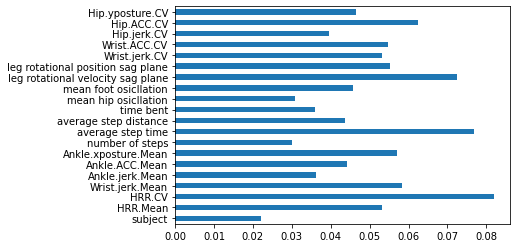

In [50]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

rfc.fit(X_train, y_train)

features = list(X)

pd.Series(rfc.feature_importances_, index=features).plot(kind='barh')

# if needed adapt the list of columns used for the generic model

#### log reg feature selection - LASSO

In [27]:
# feature selection using LASSO - based on https://towardsdatascience.com/feature-selection-in-machine-learning-using-lasso-regression-7809c7c2771a#:~:text=How%20can%20we%20use%20it,its%20coefficient%20equal%20to%200.
pipeline = Pipeline([('scaler',StandardScaler()),
                     ('model',Lasso())
                     ])

search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

# run code below to re-fit -- blended out for computational easy of code
'''search.fit(X_train,y_train)
search.best_params_
coefficients = search.best_estimator_.named_steps['model'].coef_'''

# 'model__alpha': 0.2

In [28]:
'''importance = np.abs(coefficients)
np.array(features)[importance > 0]'''

#### SVM param. selection

In [29]:
# run code below to re-fit -- blended out for computational easy of code
'''C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f" 
      % (grid.best_params_, grid.best_score_))
'''

# The best parameters are {'C': 1000.0, 'gamma': 1e-05} with a score of 0.86

'C_range = np.logspace(-2, 10, 13)\ngamma_range = np.logspace(-9, 3, 13)\nparam_grid = dict(gamma=gamma_range, C=C_range)\ncv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)\ngrid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)\ngrid.fit(X, y)\n\nprint("The best parameters are %s with a score of %0.2f" \n      % (grid.best_params_, grid.best_score_))\n'

## Model evaluation
-----

### Model evaluation - confusion matrix test & train

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_

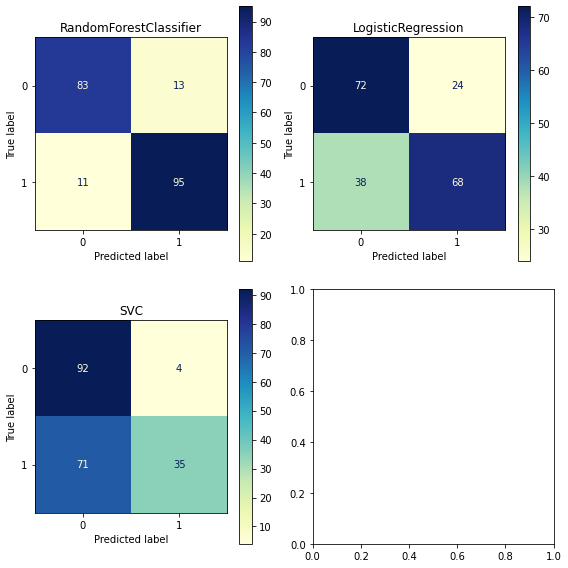

In [30]:
# test set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    cls.fit(X_train, y_train)
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_

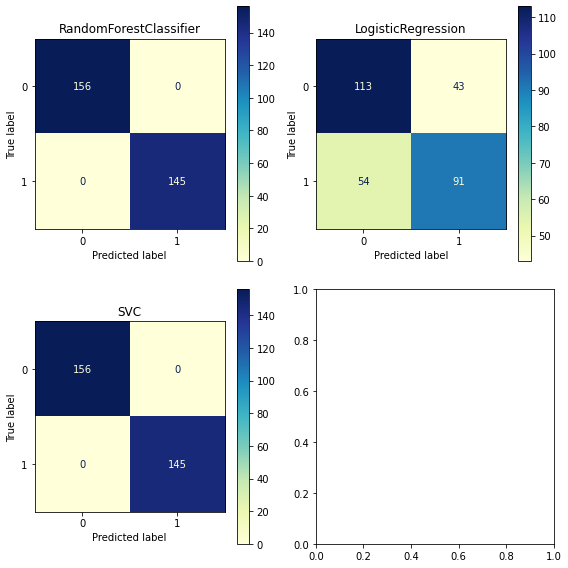

In [31]:
# double check with train set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    cls.fit(X_train, y_train)
    plot_confusion_matrix(cls, 
                          X_train, 
                          y_train, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

### Model evaluation - cross validation scores

In [32]:
# train model, get accuracies and CV
groups = X_test['subject']
gkf = GroupKFold(n_splits=4)

for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  scores = cross_val_score(model, X_test, y_test, cv=gkf, groups=groups, scoring='accuracy')
  print (f'{model}  {chr(10)} CV: {scores.mean()} {chr(10)}')

RandomForestClassifier()  
 CV: 0.6135294117647059 



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(random_state=42)  
 CV: 0.6194117647058823 

SVC(C=1000, gamma=0.01, probability=True)  
 CV: 0.5298039215686274 



### Model evaluation - classification report (precision, recall, f1, support, accuracy)
> Note: Accuracy, recall & precision are not called for when usign Decision Tree models.

In [33]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print(f'{model}: {chr(10)} {classification_report(y_test, y_pred)}')

RandomForestClassifier(): 
               precision    recall  f1-score   support

           0       0.87      0.88      0.87        96
           1       0.89      0.88      0.88       106

    accuracy                           0.88       202
   macro avg       0.88      0.88      0.88       202
weighted avg       0.88      0.88      0.88       202

LogisticRegression(random_state=42): 
               precision    recall  f1-score   support

           0       0.65      0.75      0.70        96
           1       0.74      0.64      0.69       106

    accuracy                           0.69       202
   macro avg       0.70      0.70      0.69       202
weighted avg       0.70      0.69      0.69       202

SVC(C=1000, gamma=0.01, probability=True): 
               precision    recall  f1-score   support

           0       0.56      0.96      0.71        96
           1       0.90      0.33      0.48       106

    accuracy                           0.63       202
   macro avg    

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### Model evaluation - precision/ recall

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


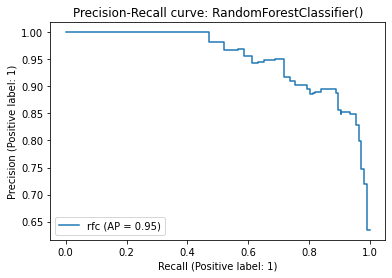

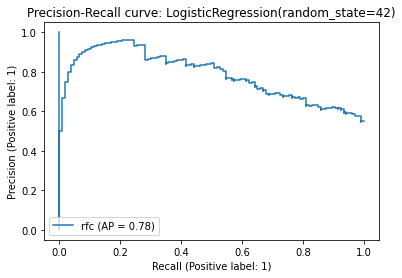

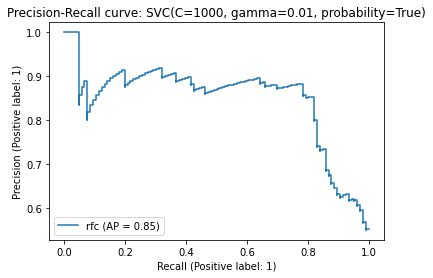

In [34]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="rfc")
  _ = display.ax_.set_title(f'Precision-Recall curve: {model}')

### Model evaluation - ROC

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


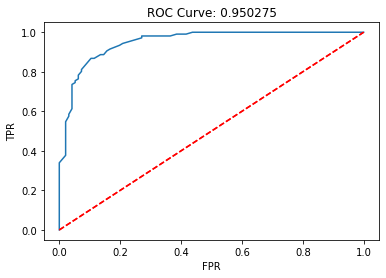

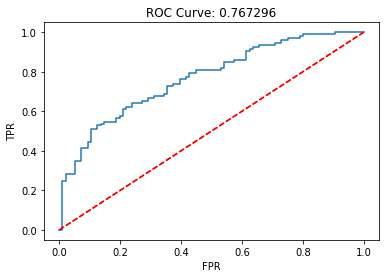

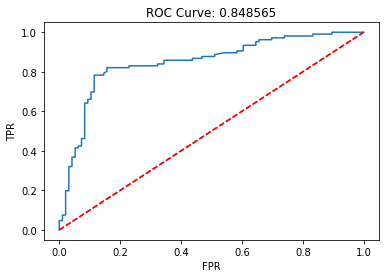

In [35]:
# scores on test set
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]
  fpr, tpr, _ = roc_curve(y_test,  y_pred)
  ax = (
      pd.DataFrame(tpr, index=fpr)
      .plot(legend=False, title=('ROC Curve: %f' % auc(fpr, tpr)))
  )
  ax.plot([(0,0), (1,1)], 'r--')
  ax.set_xlabel('FPR')
  ax.set_ylabel('TPR')

## Fairness Measure

---



We aim to check:
- **Equalised odds** (we want to ensure that the number of false negatives is equally low; we need to reduce false positives which can be costly (variable is not subjective anyways))
- **balance for negative class**
- **dispartities between exact groups**


We aim for group fairness - participants with similar characteristics should be treated similarily.


CONSIDER:
1. disaggregated evaluations - evaluating perfromance with respect to different subgroups (age/ task)



---
<br>

For supervised classification --> output should be the same accross sensitive characterisitcs - bias if the decision changes after beig exposed to additioanl sensitve feature inputs 
<br>


### Install libraries & helper functions

In [55]:
# libraries for fairness metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, 
    demographic_parity_difference, 
    demographic_parity_ratio,
    false_positive_rate, 
    false_negative_rate,
    false_positive_rate_difference, 
    false_negative_rate_difference, 
    true_positive_rate, 
    true_negative_rate,
    selection_rate,
    count,
    equalized_odds_difference)

In [37]:
# Helper functions metrics
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Equalized_odds_difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Overall balanced error rate": (
            lambda x: 1-balanced_accuracy_score(y_true, x), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
        " ------": (lambda x: "", True),
        "False positive rate difference": (
            lambda x: false_positive_rate_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

def metric_frame (feature):
    mf = MetricFrame({
        'FPR': false_positive_rate,
        'FNR': false_negative_rate,
        'TPR': true_positive_rate,
        'TNR': true_negative_rate},
        y_test, test_preds, sensitive_features = feature)
    return mf.by_group
  
def summary_as_df(name, summary):
    a = summary.by_group
    a['overall'] = summary.overall
    return pd.DataFrame({name: a})
  


### Fairness evaluation - confusion matrix by group


In [38]:
# define sensitive attributes
task = A_test['task']
age =  A_test['Age']


for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  print(f'Age:{chr(10)}{model}: {chr(10)} {metric_frame (age)} {chr(10)}')
  print(f'Task:{chr(10)}{model}: {chr(10)} {metric_frame (task)} {chr(10)}')



/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  FutureWarning)


Age:
RandomForestClassifier(): 
           FPR       FNR       TPR       TNR
Age                                        
20   0.147059       0.0       1.0  0.852941
30   0.307692       0.0       1.0  0.692308
40        0.2  0.105263  0.894737       0.8
60   0.103448  0.138889  0.861111  0.896552 

Task:
RandomForestClassifier(): 
            FPR       FNR       TPR       TNR
task                                        
1     0.232143  0.033898  0.966102  0.767857
2        0.075  0.106383  0.893617     0.925 



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Ple

Age:
LogisticRegression(random_state=42): 
           FPR       FNR       TPR       TNR
Age                                        
20   0.176471  0.459459  0.540541  0.823529
30   0.461538  0.071429  0.928571  0.538462
40       0.45  0.263158  0.736842      0.55
60   0.241379  0.388889  0.611111  0.758621 

Task:
LogisticRegression(random_state=42): 
            FPR       FNR       TPR       TNR
task                                        
1     0.339286   0.40678   0.59322  0.660714
2        0.225  0.276596  0.723404     0.775 

Age:
SVC(C=1000, gamma=0.01, probability=True): 
           FPR       FNR       TPR       TNR
Age                                        
20   0.529412  0.135135  0.864865  0.470588
30   0.769231  0.071429  0.928571  0.230769
40       0.45  0.105263  0.894737      0.55
60   0.517241  0.083333  0.916667  0.482759 

Task:
SVC(C=1000, gamma=0.01, probability=True): 
            FPR       FNR       TPR       TNR
task                                        
1     

/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  FutureWarning)


### Fairness evaluation - fairness metrics by group (equalized odds, demographic parity difference & ratio, false negative rate difference)

In [39]:
# Metrics 
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  models_dict = {"Unmitigated": (test_preds, y_pred)}

  print(f'Age:{chr(10)}{model}: {chr(10)} {get_metrics_df(models_dict, y_test, age)} {chr(10)}')


Age:
RandomForestClassifier(): 
                                Unmitigated
Equalized_odds_difference         0.334615
Demographic parity difference     0.216524
Demographic parity ratio          0.692308
------                                    
Overall balanced error rate       0.121069
Balanced error rate difference    0.140992
 ------                                   
False positive rate difference    0.334615
False negative rate difference    0.166667
Equalized odds difference         0.334615
  ------                                  
Overall AUC                       0.943691
AUC difference                    0.044766 



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Age:
LogisticRegression(random_state=42): 
                                Unmitigated
Equalized_odds_difference         0.388031
Demographic parity difference     0.337507
Demographic parity ratio          0.520385
------                                    
Overall balanced error rate       0.320362
Balanced error rate difference    0.090095
 ------                                   
False positive rate difference    0.285068
False negative rate difference    0.388031
Equalized odds difference         0.388031
  ------                                  
Overall AUC                       0.767296
AUC difference                    0.074639 

Age:
SVC(C=1000, gamma=0.01, probability=True): 
                                Unmitigated
Equalized_odds_difference         0.319231
Demographic parity difference     0.185185
Demographic parity ratio          0.782609
------                                    
Overall balanced error rate        0.32272
Balanced error rate difference    0.142698
 

In [40]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  models_dict = {"Unmitigated": (test_preds, y_pred)}

  print(f'Task:{chr(10)}{model}: {chr(10)} {get_metrics_df(models_dict, y_test, task)} {chr(10)}')

Task:
RandomForestClassifier(): 
                                Unmitigated
Equalized_odds_difference         0.103571
Demographic parity difference     0.036482
Demographic parity ratio          0.935455
------                                    
Overall balanced error rate       0.105444
Balanced error rate difference    0.043131
 ------                                   
False positive rate difference    0.103571
False negative rate difference     0.01731
Equalized odds difference         0.103571
  ------                                  
Overall AUC                       0.967718
AUC difference                    0.012535 

Task:
LogisticRegression(random_state=42): 
                                Unmitigated
Equalized_odds_difference         0.130184
Demographic parity difference     0.024688
Demographic parity ratio          0.950051
------                                    
Overall balanced error rate       0.320362
Balanced error rate difference    0.122235
 ------         

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Task:
SVC(C=1000, gamma=0.01, probability=True): 
                                Unmitigated
Equalized_odds_difference         0.217857
Demographic parity difference     0.149325
Demographic parity ratio          0.819565
------                                    
Overall balanced error rate       0.338345
Balanced error rate difference    0.073047
 ------                                   
False positive rate difference    0.217857
False negative rate difference    0.071763
Equalized odds difference         0.217857
  ------                                  
Overall AUC                       0.848418
AUC difference                    0.054474 



##### helper function for visualisation


In [53]:
# demographic disparity
# https://github.com/fairlearn/fairlearn/blob/main/notebooks/Mitigating%20Disparities%20in%20Ranking%20from%20Binary%20Data.ipynb

from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy.stats import cumfreq

def compare_cdfs(data, A, num_bins=100):
    cdfs = {}
    assert len(np.unique(A)) == 4 ### change to 4/2 depending on the sensitive attribute (Age vs. task)
    
    limits = ( min(data), max(data) )
    s = 0.5 * (limits[1] - limits[0]) / (num_bins - 1)
    limits = ( limits[0]-s, limits[1] + s)
    
    for a in np.unique(A):
        subset = data[A==a]
        
        cdfs[a] = cumfreq(subset, numbins=num_bins, defaultreallimits=limits)
        
    lower_limits = [v.lowerlimit for _, v in cdfs.items()]
    bin_sizes = [v.binsize for _,v in cdfs.items()]
    actual_num_bins = [v.cumcount.size for _,v in cdfs.items()]
    
    assert len(np.unique(lower_limits)) == 1
    assert len(np.unique(bin_sizes)) == 1
    assert np.all([num_bins==v.cumcount.size for _,v in cdfs.items()])
    
    xs = lower_limits[0] + np.linspace(0, bin_sizes[0]*num_bins, num_bins)
    
    disparities = np.zeros(num_bins)
    for i in range(num_bins):
        cdf_values = np.clip([v.cumcount[i]/len(data[A==k]) for k,v in cdfs.items()],0,1)
        disparities[i] = max(cdf_values)-min(cdf_values)  
    
    return xs, cdfs, disparities
    
    
def plot_and_compare_cdfs(data, A, num_bins=100, loc='best'):
    xs, cdfs, disparities = compare_cdfs(data, A, num_bins)
    
    for k, v in cdfs.items():
        plt.plot(xs, v.cumcount/len(data[A==k]), label=k)
    
    assert disparities.argmax().size == 1
    d_idx = disparities.argmax()
    
    xs_line = [xs[d_idx],xs[d_idx]]
    counts = [v.cumcount[d_idx]/len(data[A==k]) for k, v in cdfs.items()]
    ys_line = [min(counts), max(counts)]
    
    plt.plot(xs_line, ys_line, 'o--')
    disparity_label = "max disparity = {0:.3f}\nat {1:0.3f}".format(disparities[d_idx], xs[d_idx])
    plt.text(xs[d_idx], 1, disparity_label, ha="right", va="top")
    
    plt.ylabel("cumulative frequency")
    plt.legend(loc=loc)
    plt.show()

#### Visualisation - performance metric by groups (age)


---



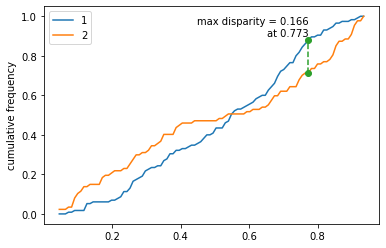

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


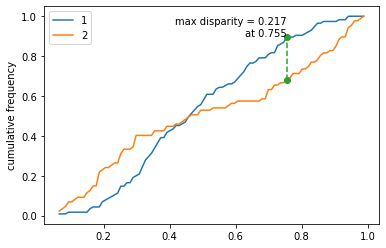

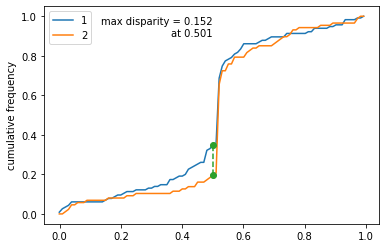

In [43]:
%matplotlib inline

for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1


  display(HTML('<span id="disparity_unmitigated">'))
  plot_and_compare_cdfs(y_pred, task)
  display(HTML('</span>'))

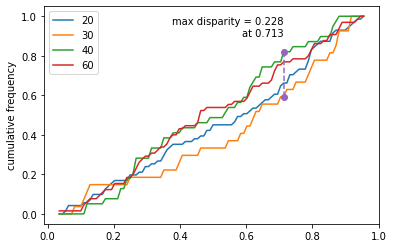

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


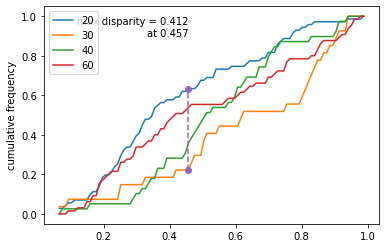

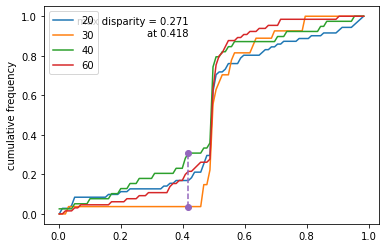

In [52]:
%matplotlib inline

for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1


  display(HTML('<span id="disparity_unmitigated">'))
  plot_and_compare_cdfs(y_pred, age)
  display(HTML('</span>'))

# Debiasing the model

---


In this part we aim to mitigate bias (removing the problematic signal) through the addition of inclusion (add singal for deasired features for a re-weighted singal to improved fairness)

The dataset is not balanced for any of the groups present (different sample numbers) 


#### Reminder to types of fairness and how to approach them

- Demographic parity applies different classifciaiton thresholds per group while keeping the same fraction of +ives
- Equal opp. uses different classifciaiton thresholds per group while keeping the same true positive rate
- Equalized odds uses different classifciaiton thresholds per group while keeping the same true positive&false rate


**We aim for equalized odds (EO) and ERP (error rate parity) cross groups.**


#### De-biasing methods overview:

 - pre-processing: reweighing, disparate impact remover

 - in-process: adversarial debiasing, prejudice remover

- post process-process: through reductions: Exponential gradient (for disparity mitigation), Gridsearch,  ThresholdOptimizer, equalized odds/ calibrated offd/ reject option classification


> NOTE: fairlearn only supports binary classificaiton 



STEPS:
1. Pre-processing 
    - reweigh sample 
    - balance perfromance metric (already the case equal number of stressed/ non stressed people

2. in process 
    - adversarial debiasing

3. post process 
    - threshold optimizer, equalizedodds






#### import libraries and helper functions

In [56]:
import aif360

from aif360.datasets import StandardDataset
from sklearn.pipeline import make_pipeline 

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import DatasetMetric

from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.inprocessing import PrejudiceRemover

# Additional fairlearn libraries
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation

from fairlearn.reductions import (ExponentiatedGradient, 
                                  EqualizedOdds, 
                                  TruePositiveRateParity,
                                  GridSearch)

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

#### 1. Reweigh samples for age (AIF360)

Based on:
1. [Correcting Unfair Binary Classification
Models](http://arno.uvt.nl/show.cgi?fid=157880)

2. [AIF360 example](https://nbviewer.org/github/IBM/AIF360/blob/master/examples/tutorial_credit_scoring.ipynb)


In [57]:
# set dataset in aif360 format
ds_aif = aif360.datasets.StandardDataset (df, 
                                         label_name="fatiguestate",
                                         favorable_classes = [1], 
                                         protected_attribute_names=['Age', 'task'], 
                                         privileged_classes= [lambda x: x >= 31],
                                         features_to_drop=['subject'])

In [60]:
# test, train split
ds_train, ds_test = ds_aif.split([0.7], shuffle=True)

In [61]:
# pre-processing - reweighing 
# define priviledged & unpriviledged groups
unpriv = [{'Age': 0}]
priv = [{'Age': 1}]

# reweigh
RW = Reweighing (unprivileged_groups = unpriv, 
                 privileged_groups = priv)

RW_train = RW.fit_transform(ds_train)

In [63]:
# check for metric before and after transforming 
# OG dataset
metric_train = BinaryLabelDatasetMetric(ds_train,
                                        unprivileged_groups = unpriv,
                                        privileged_groups = priv)

explainer_train = MetricTextExplainer(metric_train)

# transformed dataset
metric_transf_train = BinaryLabelDatasetMetric(RW_train,
                                               unprivileged_groups=unpriv,
                                               privileged_groups=priv)

explainer_transf_train = MetricTextExplainer(metric_transf_train)

display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train.mean_difference())
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())


display(Markdown("#### Disparate impact"))
print(f'Before reweighing {explainer_train.disparate_impact()}')
print(f'After reweighing {explainer_transf_train.disparate_impact()}')

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.022774


#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


#### Disparate impact

Before reweighing Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.046659597030753
After reweighing Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0000000000000002


In [64]:
# refit rfc model & get metrics
X_train = RW_train.features
y_train = RW_train.labels.ravel()
w_train = RW_train.instance_weights

X_test = ds_test.features
y_test = ds_test.labels.ravel()

##### Evaluations

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the cl

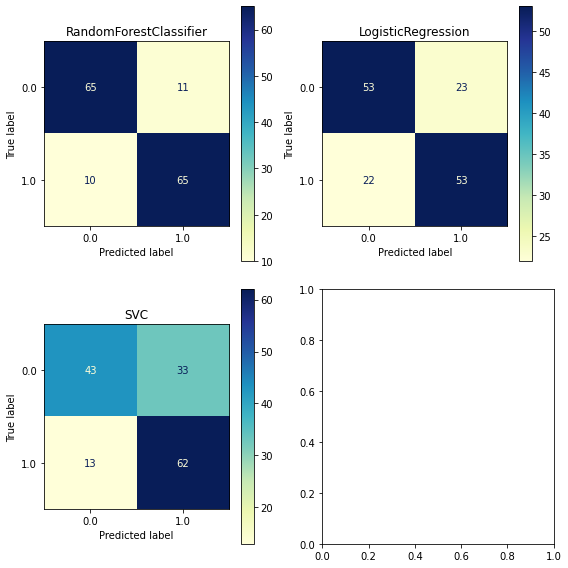

In [66]:
# confusion matrix

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    # train models with reweighted data
    dataset = RW_train
    cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
    
    # plot
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)

plt.tight_layout()
plt.show()

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the cl

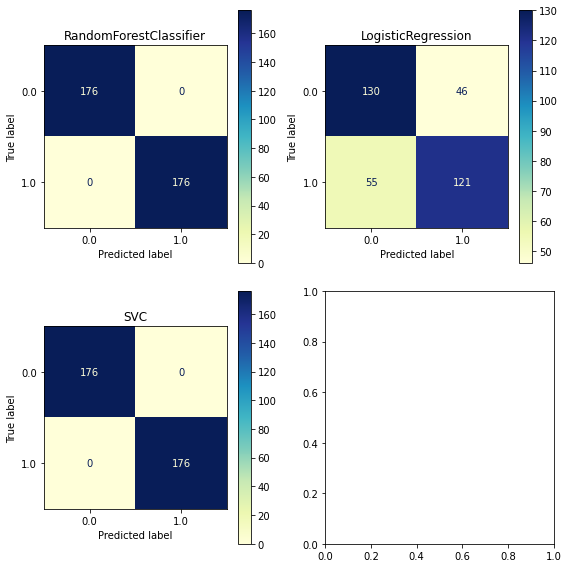

In [67]:
# double check with train set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    dataset = RW_train
    cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
    plot_confusion_matrix(cls, 
                          X_train, 
                          y_train, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

In [68]:
# get classification reports
for cls in classifiers:
  dataset = RW_train
  cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
  y_pred = cls.predict(X_test)
  
  print(f'{cls}: {chr(10)} {classification_report(y_test, y_pred)}')

RandomForestClassifier(): 
               precision    recall  f1-score   support

         0.0       0.91      0.89      0.90        76
         1.0       0.89      0.91      0.90        75

    accuracy                           0.90       151
   macro avg       0.90      0.90      0.90       151
weighted avg       0.90      0.90      0.90       151

LogisticRegression(random_state=42): 
               precision    recall  f1-score   support

         0.0       0.71      0.70      0.70        76
         1.0       0.70      0.71      0.70        75

    accuracy                           0.70       151
   macro avg       0.70      0.70      0.70       151
weighted avg       0.70      0.70      0.70       151

SVC(C=1000, gamma=0.01, probability=True): 
               precision    recall  f1-score   support

         0.0       0.77      0.57      0.65        76
         1.0       0.65      0.83      0.73        75

    accuracy                           0.70       151
   macro avg    

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


##### Fairness evaluations

In [69]:
# define test 
ds_test_pred = ds_test.copy(deepcopy=True)

In [80]:
for cls in classifiers:

  cls.fit(RW_train.features, RW_train.labels.ravel(), sample_weight = dataset.instance_weights)
  y_pred = cls.predict(X_test)
  
  # scores on test set
  ds_test_pred.scores = cls.predict_proba(X_test)[:1]

  # predictions (0 or 1) on test set
  y_train_pred = cls.predict(X_train)
  test_preds = (y_pred >= np.mean(y_train)) * 1

  models_dict = {"Unmitigated": (test_preds, y_pred)}

  print(f'Age:{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, age)} {chr(10)}')
  
  print(f'Age:{chr(10)}{cls}: {chr(10)} {metric_frame (age)} {chr(10)}')

X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


Age:
RandomForestClassifier(): 
                                Unmitigated
Equalized_odds_difference         0.083333
Demographic parity difference     0.051282
Demographic parity ratio          0.904762
------                                    
Overall balanced error rate       0.034493
Balanced error rate difference    0.076149
 ------                                   
False positive rate difference    0.068966
False negative rate difference    0.083333
Equalized odds difference         0.083333
  ------                                  
Overall AUC                       0.965507
AUC difference                    0.076149 

Age:
RandomForestClassifier(): 
           FPR       FNR       TPR       TNR
Age                                        
20   0.029412  0.027027  0.972973  0.970588
30        0.0       0.0       1.0       1.0
40        0.0       0.0       1.0       1.0
60   0.068966  0.083333  0.916667  0.931034 



You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names


Age:
LogisticRegression(random_state=42): 
                                Unmitigated
Equalized_odds_difference          0.25355
Demographic parity difference     0.158059
Demographic parity ratio          0.796781
------                                    
Overall balanced error rate       0.390232
Balanced error rate difference    0.217838
 ------                                   
False positive rate difference     0.25355
False negative rate difference        0.25
Equalized odds difference          0.25355
  ------                                  
Overall AUC                       0.609768
AUC difference                    0.217838 

Age:
LogisticRegression(random_state=42): 
           FPR       FNR       TPR       TNR
Age                                        
20   0.470588  0.243243  0.756757  0.529412
30   0.538462       0.0       1.0  0.461538
40       0.55  0.210526  0.789474      0.45
60   0.724138      0.25      0.75  0.275862 



You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
X has feature names, but SVC was fitted without feature names
X has feature names, but SVC was fitted without feature names
X has feature names, but SVC was fitted without feature names


Age:
SVC(C=1000, gamma=0.01, probability=True): 
                                Unmitigated
Equalized_odds_difference         0.236074
Demographic parity difference     0.189744
Demographic parity ratio          0.771605
------                                    
Overall balanced error rate       0.268868
Balanced error rate difference    0.082323
 ------                                   
False positive rate difference    0.236074
False negative rate difference    0.157895
Equalized odds difference         0.236074
  ------                                  
Overall AUC                       0.731132
AUC difference                    0.082323 

Age:
SVC(C=1000, gamma=0.01, probability=True): 
           FPR       FNR       TPR       TNR
Age                                        
20   0.470588       0.0       1.0  0.529412
30   0.384615  0.071429  0.928571  0.615385
40       0.45  0.157895  0.842105      0.55
60    0.62069       0.0       1.0   0.37931 



You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.


#### 2. Adverserial debiasing (AIF360)
Not used for report - needs to be further analyzed for the correct use/integration 

In [71]:
metric_orig_train = BinaryLabelDatasetMetric(ds_train, 
                                            unprivileged_groups = unpriv,
                                            privileged_groups = priv)
display(Markdown("#### Original training dataset"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(ds_test, 
                                            unprivileged_groups = unpriv,
                                            privileged_groups = priv)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Train set: Difference in mean outcomes between unprivileged and privileged groups = 0.022774
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.061123


In [ ]:
# Load post-processing algorithm that equalizes the odds
# Learn parameters with debias set to False
import tensorflow.compat.v1 as tf

tf.disable_eager_execution()

sess = tf.Session()
sess.close()

tf.reset_default_graph()
sess = tf.Session()

debiased_model = AdversarialDebiasing(privileged_groups = priv,
                                                   unprivileged_groups = unpriv,
                                                   scope_name = 'plain_classifier',
                                                   debias = True,
                                                   sess=sess)

debiased_model.fit(ds_train)

In [73]:
# Apply the plain model to test data
ds_debiasing_train = debiased_model.predict(ds_train)
ds_debiasing_test = debiased_model.predict(ds_test)

In [74]:
# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(ds_debiasing_train, 
                                                          privileged_groups = priv,
                                                          unprivileged_groups = unpriv,)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(ds_debiasing_test, 
                                                         privileged_groups = priv,
                                                         unprivileged_groups = unpriv,)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())



#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.097050
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.055082


https://nbviewer.org/github/Trusted-AI/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb#3.-Training-models-on-original-2015-Panel-19-data

##### model evaluation


#### Fair learn - post processign methods



In [75]:
# set test & train data & defining age as sensitive attribute
X = df.drop(columns=['Age', 'fatiguestate'])
y = df['fatiguestate']

A = df[['Age']]

# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test, A_str_train, A_str_test = train_test_split(
    X, 
    y, 
    A, 
    task_str,
    test_size = 0.4, # increse number for more fairness 
    random_state=42)


In [76]:
# define metrics that want to be influenced
metrics_dict = {"false_negative_rate": false_negative_rate,         
                "selection_rate": selection_rate,
                "balanced_accuracy": balanced_accuracy_score
                ,}

In [78]:
# train unmitigated pipeline & get results to compare with results later
for cls in classifiers:
  unmitigated_pipeline = Pipeline(steps=[("model", cls)])

  unmitigated_pipeline.fit(X_train, y_train)

  Y_pred = unmitigated_pipeline.predict(X_test)

  mf1 = MetricFrame(metrics=false_negative_rate,
                    y_true=y_test,
                    y_pred=Y_pred,
                    sensitive_features=A_test)

# The disaggregated metrics are stored in a pandas Series mf1.by_group:

  print(f"{cls}:\n {mf1.by_group}\n"
        f"difference: {mf1.difference():.3}\n"
        f"ratio: {mf1.ratio():.3}\n"
        f"max across groups: {mf1.group_max():.3}\n"
         f"balanced_accuracy_score: {balanced_accuracy_score(y_test, Y_pred)}\n\n")

RandomForestClassifier():
 Age
20    0.054054
30         0.0
40    0.105263
60    0.166667
Name: false_negative_rate, dtype: object
difference: 0.167
ratio: 0.0
max across groups: 0.167
balanced_accuracy_score: 0.8747051886792453


LogisticRegression(random_state=42):
 Age
20    0.486486
30    0.071429
40    0.263158
60    0.388889
Name: false_negative_rate, dtype: object
difference: 0.415
ratio: 0.147
max across groups: 0.486
balanced_accuracy_score: 0.7009630503144654


SVC(C=1000, gamma=0.01, probability=True):
 Age
20    0.594595
30         0.5
40    0.684211
60    0.805556
Name: false_negative_rate, dtype: object
difference: 0.306
ratio: 0.621
max across groups: 0.806
balanced_accuracy_score: 0.6442610062893082




lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


#### 3. ExponentiatedGradient - reduction (fair learn)

In [79]:
# train exponentialgradient for each classifier
# get metrics resuts
for cls in classifiers:
  expgrad_est = ExponentiatedGradient(estimator=cls,
                                    constraints=TruePositiveRateParity(difference_bound=0.07)) # for FNR 1-TPR
  
  expgrad_est.fit(X_train, y_train, sensitive_features=A_train)
  
  Y_pred_reductions = expgrad_est.predict(X_test, random_state=42)
  
  metricframe_reductions = MetricFrame(metrics=metrics_dict,
                                       y_true=y_test,
                                       y_pred=Y_pred_reductions,
                                       sensitive_features=A_test)
  metricframe_reductions.by_group

  # Evaluate the difference between the largest and smallest value of each metric
  print(f'{cls}:\n',
        f'{metricframe_reductions.difference()} \n\n')


Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Seri

RandomForestClassifier():
 false_negative_rate    0.194444
selection_rate         0.168091
balanced_accuracy      0.163245
dtype: object 




Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to 

LogisticRegression(random_state=42):
 false_negative_rate    0.169275
selection_rate         0.124152
balanced_accuracy       0.06526
dtype: object 




Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Seri

SVC(C=1000, gamma=0.01, probability=True):
 false_negative_rate    0.305556
selection_rate         0.173219
balanced_accuracy      0.131558
dtype: object 




Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


#### 4. Thresholdoptimizer (fair learn - post processing)

ThresholdOptimizer takes in an exisiting (possibly pre-fit) machine learning model whose predictions act as a scoring function and identifies a separate thrceshold for each group in order to optimize some specified objective metric (such as balanced accuracy) subject to specified fairness constraints (such as false negative rate parity). Thus, the resulting classifier is just a suitably thresholded version of the underlying machinelearning model.

In [81]:
# fit thesholdoptimizer for each classifier and return mitigated resutls
for cls in classifiers:  
  postprocess_est = ThresholdOptimizer(estimator=unmitigated_pipeline,
                                       constraints="false_negative_rate_parity",
                                       objective="balanced_accuracy_score",
                                       prefit=True,
                                       predict_method='predict_proba')
  
  postprocess_est.fit(X_train, y_train, sensitive_features=A_train)

  Y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test)

  metricframe_postprocess = MetricFrame(metrics=metrics_dict,
                                        y_true=y_test,
                                        y_pred=Y_pred_postprocess,
                                        sensitive_features=A_test)
  
  df_results = pd.concat([metricframe_postprocess.by_group],
                          keys=['Unmitigated', 'ThresholdOptimizer'],
                          axis=1)
  
  print (f'{cls} - Age:{chr(10)} {df_results}{chr(10)}')
  

X has feature names, but SVC was fitted without feature names
X has feature names, but SVC was fitted without feature names
X has feature names, but SVC was fitted without feature names


RandomForestClassifier() - Age:
             Unmitigated                                 
    false_negative_rate selection_rate balanced_accuracy
Age                                                     
20                  0.0       0.746479          0.764706
30                  0.0       0.740741          0.769231
40             0.105263       0.666667          0.722368
60             0.027778       0.784615          0.710249



X has feature names, but SVC was fitted without feature names
X has feature names, but SVC was fitted without feature names


LogisticRegression(random_state=42) - Age:
             Unmitigated                                 
    false_negative_rate selection_rate balanced_accuracy
Age                                                     
20                  0.0       0.746479          0.764706
30             0.071429       0.703704          0.733516
40             0.105263       0.666667          0.722368
60                  0.0       0.830769          0.689655

SVC(C=1000, gamma=0.01, probability=True) - Age:
             Unmitigated                                 
    false_negative_rate selection_rate balanced_accuracy
Age                                                     
20                  0.0       0.746479          0.764706
30                  0.0       0.740741          0.769231
40             0.105263       0.666667          0.722368
60             0.111111       0.753846          0.651341



X has feature names, but SVC was fitted without feature names


# ML fairness - summary and future considerations (for report)


---





Best practices:
  - dataset documentation
  -  model reporting and curation
  - reproducibility and transparency



The Model Card Toolkit (MCT) will be used to ensure the correct documentation, model reporting, and transaparency of the set-up model

https://github.com/tensorflow/model-card-toolkit

https://github.com/fairlearn/talks/blob/main/2021_scipy_tutorial/fairness-in-AI-systems-instructors.ipynb



https://github.com/fairlearn/talks/blob/main/2022_pycon/pycon-2022-instructors.ipynb

In [ ]:
# ! pip install model-card-toolkit

In [ ]:
try:
    from model_card_toolkit import ModelCardToolkit
    from model_card_toolkit.utils.graphics import figure_to_base64str
    model_card_imported = True
except Exception:
    model_card_imported = False
    def figure_to_base64str(*args):
        return None

In [ ]:
# Initialize the Model Card Toolkit with a path to store generate assets
model_card_output_path = ...
mct = model_card_toolkit.ModelCardToolkit(model_card_output_path)

# Initialize the model_card_toolkit.ModelCard, which can be freely populated
model_card = mct.scaffold_assets()
model_card.model_details.name = 'My Model'

# Write the model card data to a proto file
mct.update_model_card(model_card)

# Return the model card document as an HTML page
html = mct.export_format()

In [ ]:
# for graphics: https://github.com/valeria-io/bias-in-credit-models/blob/master/model_analysis/model_fairness_interventions.ipynb
go for negative rate 

## archive of code snipplets


In [ ]:
# proof scaling doesnt mke a difference

from sklearn.preprocessing import StandardScaler, MaxAbsScaler

min_max_scaler = MaxAbsScaler()
ds_train.features = min_max_scaler.fit_transform(ds_train.features)
ds_test.features = min_max_scaler.transform(ds_test.features)
metric_scaled_train = BinaryLabelDatasetMetric(ds_train, 
                            unprivileged_groups = unpriv,
                                            privileged_groups = priv)
display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(ds_test, 
                            unprivileged_groups = unpriv,
                                            privileged_groups = priv)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())

check : https://colab.research.google.com/github/fairlearn/talks/blob/main/2021_scipy_tutorial/fairness-in-AI-systems-student.ipynb#scrollTo=HrCelj5_hR6a


'''https://fairlearn.org/v0.5.0/quickstart.html

https://github.com/fairlearn/talks/blob/main/2021_scipy_tutorial/fairness-in-AI-systems-instructors.ipynb

https://github.com/fairlearn/fairlearn/tree/main/notebooks'''




https://www.ibm.com/docs/en/cloud-paks/cp-data/3.5.0?topic=functions-watson-machine-learning-overview


https://proceedings.neurips.cc/paper/2020/file/03593ce517feac573fdaafa6dcedef61-Paper.pdf

https://proceedings.neurips.cc/paper/2021/file/43c656628a4a479e108ed86f7a28a010-Paper.pdf


https://arxiv.org/pdf/1810.01943.pdf


